In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal  # 频域分析
from scipy.spatial.transform import Rotation  # 四元数转欧拉角
import plotly.express as px  # 交互式可视化

In [17]:
df = pd.read_csv('output.csv')
df = df.iloc[2:].reset_index(drop=True)

In [18]:
# 处理时间戳（单位为毫秒）
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

In [19]:
# 将四元数转换为欧拉角（弧度）
def quaternion_to_euler(x, y, z, w):
    rotation = Rotation.from_quat([x, y, z, w])
    return rotation.as_euler('xyz')  # 返回 roll, pitch, yaw


# 为原始和滤波数据添加欧拉角列
df[['imu_roll', 'imu_pitch', 'imu_yaw']] = df.apply(
    lambda row: quaternion_to_euler(row['imu_quaternion_x'], row['imu_quaternion_y'],
                                    row['imu_quaternion_z'], row['imu_quaternion_w']), axis=1, result_type='expand'
)

df[['kf_roll', 'kf_pitch', 'kf_yaw']] = df.apply(
    lambda row: quaternion_to_euler(row['kf_quaternion_x'], row['kf_quaternion_y'],
                                    row['kf_quaternion_z'], row['kf_quaternion_w']), axis=1, result_type='expand'
)

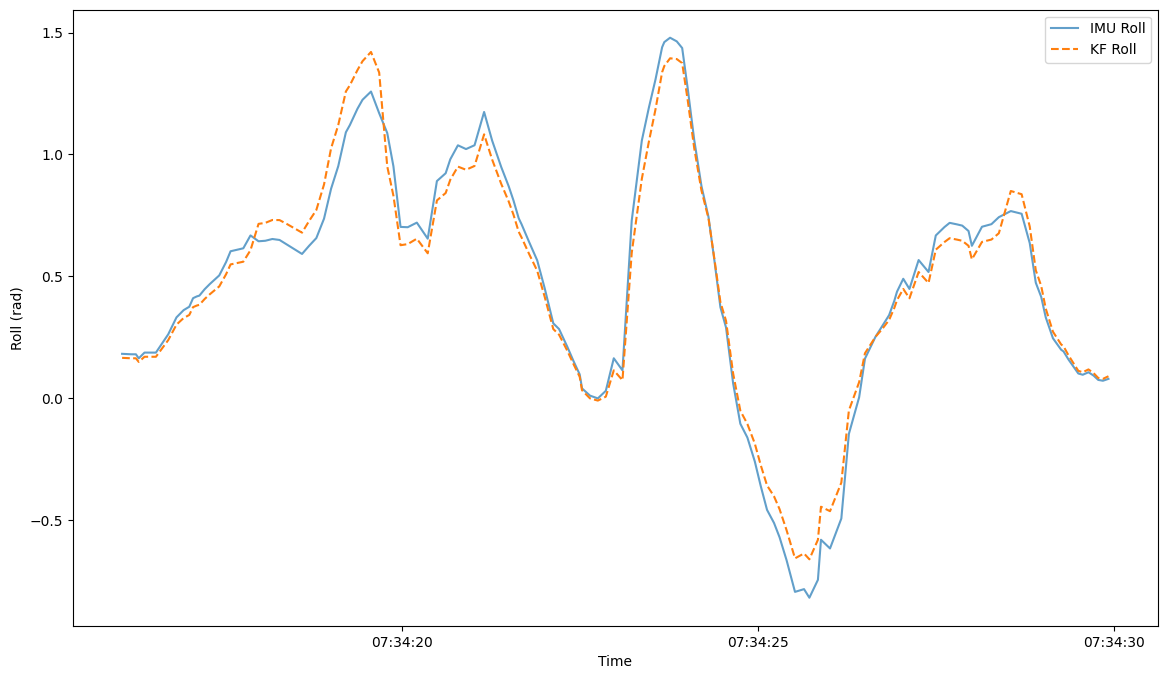

In [20]:
# 可视化姿态角对比
plt.figure(figsize=(14, 8))
plt.plot(df['timestamp'], df['imu_roll'], label='IMU Roll', alpha=0.7)
plt.plot(df['timestamp'], df['kf_roll'], label='KF Roll', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Roll (rad)')
plt.legend()
plt.show()

In [21]:
# 计算加速度统计量
acc_stats = df[[
    'imu_acceleration_x', 'imu_acceleration_y', 'imu_acceleration_z',
    'kf_acceleration_x', 'kf_acceleration_y', 'kf_acceleration_z'
]].agg(['mean', 'std', 'min', 'max'])

print("加速度统计量:\n", acc_stats)

加速度统计量:
       imu_acceleration_x  imu_acceleration_y  imu_acceleration_z  \
mean            0.133210           -0.041697            0.040959   
std             0.639563            0.425914            0.835985   
min            -1.500000           -1.500000           -2.100000   
max             2.900000            1.600000            5.000000   

      kf_acceleration_x  kf_acceleration_y  kf_acceleration_z  
mean           0.121209          -0.037941           0.037269  
std            0.581945           0.387544           0.760671  
min           -1.364865          -1.364865          -1.910811  
max            2.638739           1.455856           4.549550  


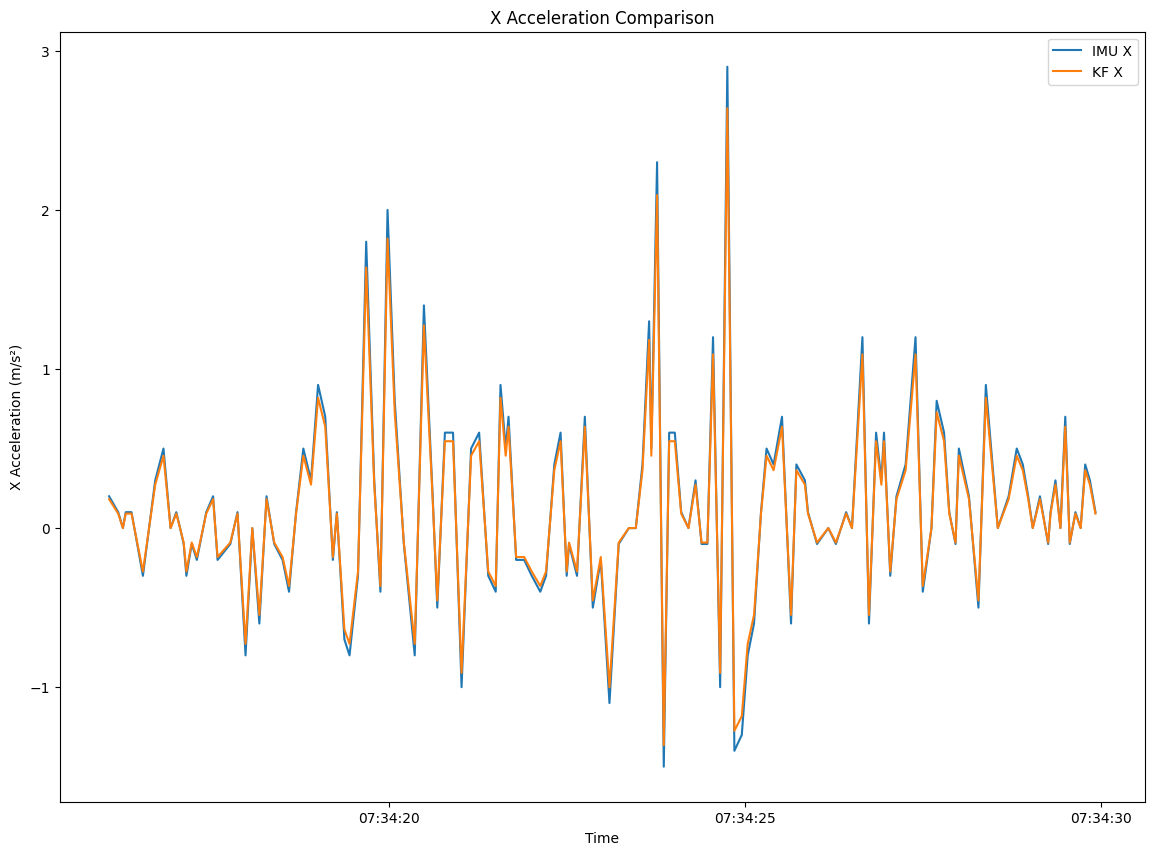

In [22]:
# 绘制 X 加速度时间序列
plt.figure(figsize=(14, 10))
plt.plot(df['timestamp'], df['imu_acceleration_x'], label='IMU X')
plt.plot(df['timestamp'], df['kf_acceleration_x'], label='KF X')
plt.xlabel('Time')
plt.ylabel('X Acceleration (m/s²)')
plt.legend()
plt.title('X Acceleration Comparison')
plt.show()

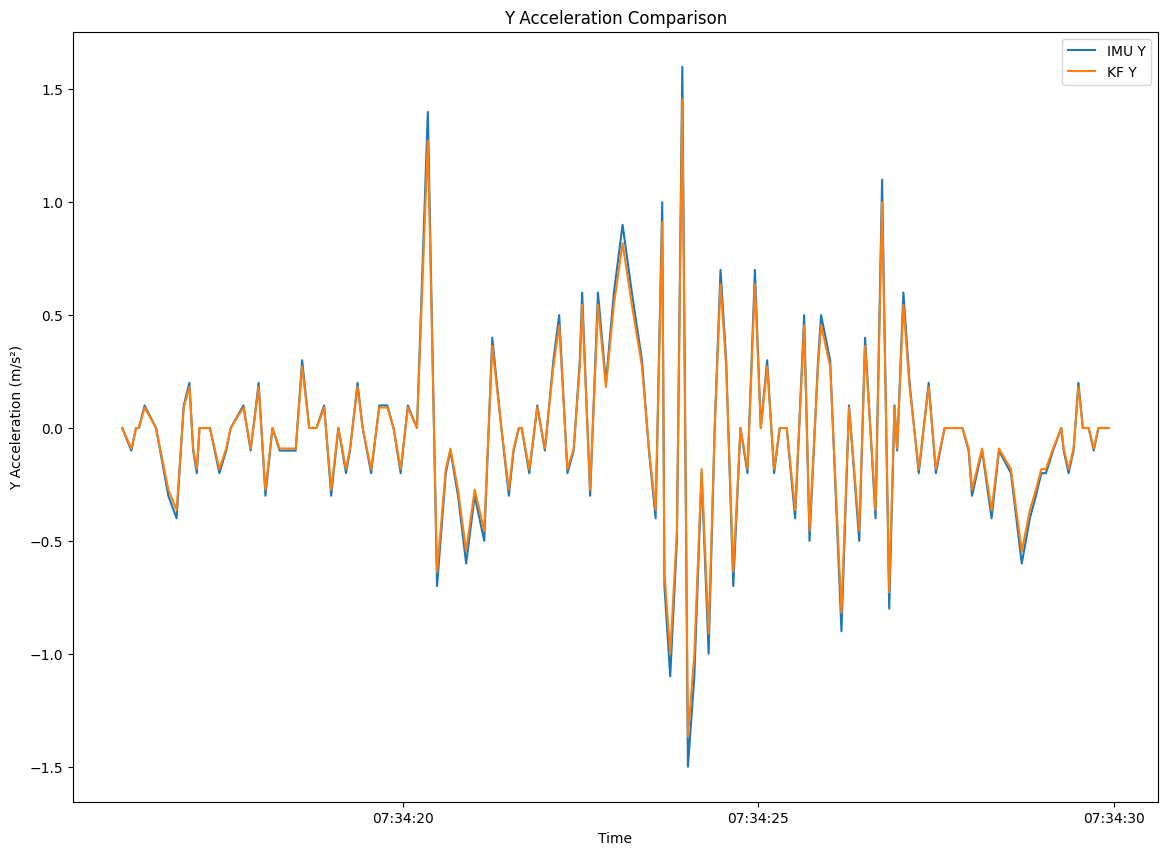

In [23]:
# 绘制 Y 加速度时间序列
plt.figure(figsize=(14, 10))
plt.plot(df['timestamp'], df['imu_acceleration_y'], label='IMU Y')
plt.plot(df['timestamp'], df['kf_acceleration_y'], label='KF Y')
plt.xlabel('Time')
plt.ylabel('Y Acceleration (m/s²)')
plt.legend()
plt.title('Y Acceleration Comparison')
plt.show()

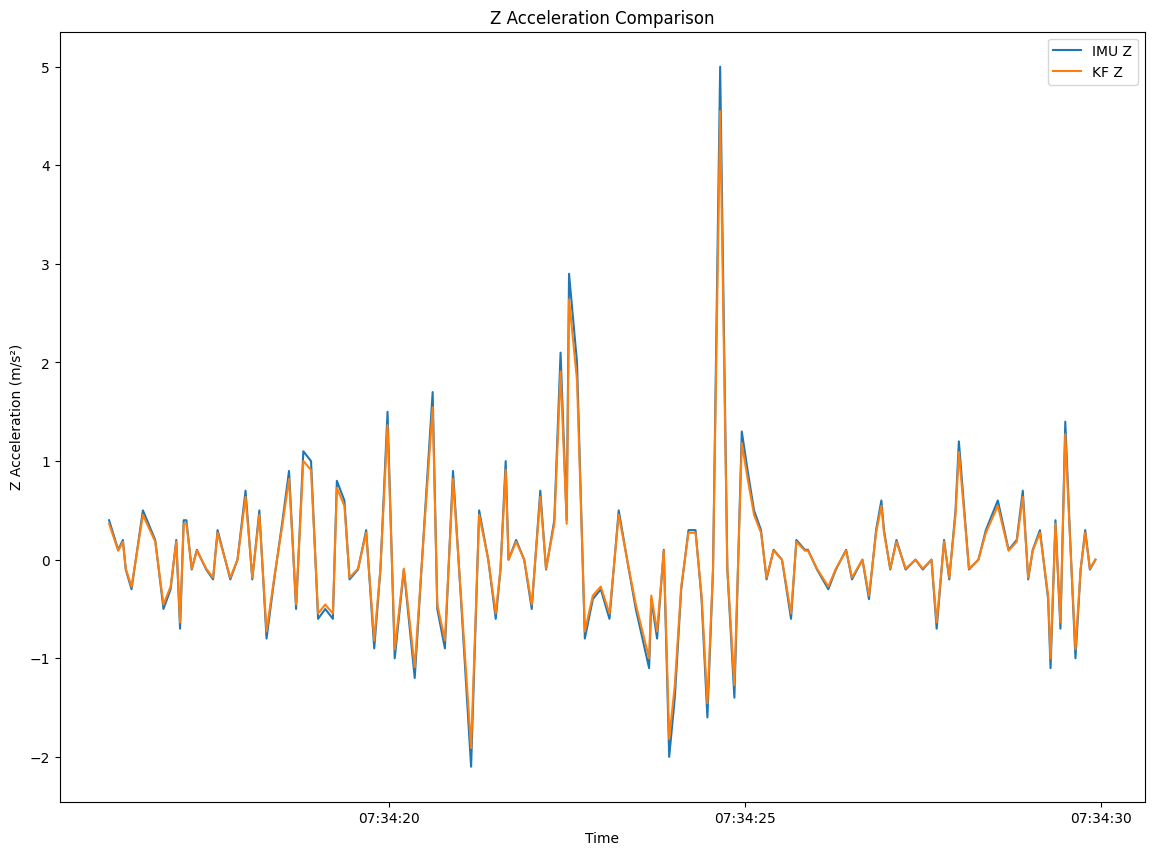

In [24]:
# 绘制 Z 加速度时间序列
plt.figure(figsize=(14, 10))
plt.plot(df['timestamp'], df['imu_acceleration_z'], label='IMU Z')
plt.plot(df['timestamp'], df['kf_acceleration_z'], label='KF Z')
plt.xlabel('Time')
plt.ylabel('Z Acceleration (m/s²)')
plt.legend()
plt.title('Z Acceleration Comparison')
plt.show()

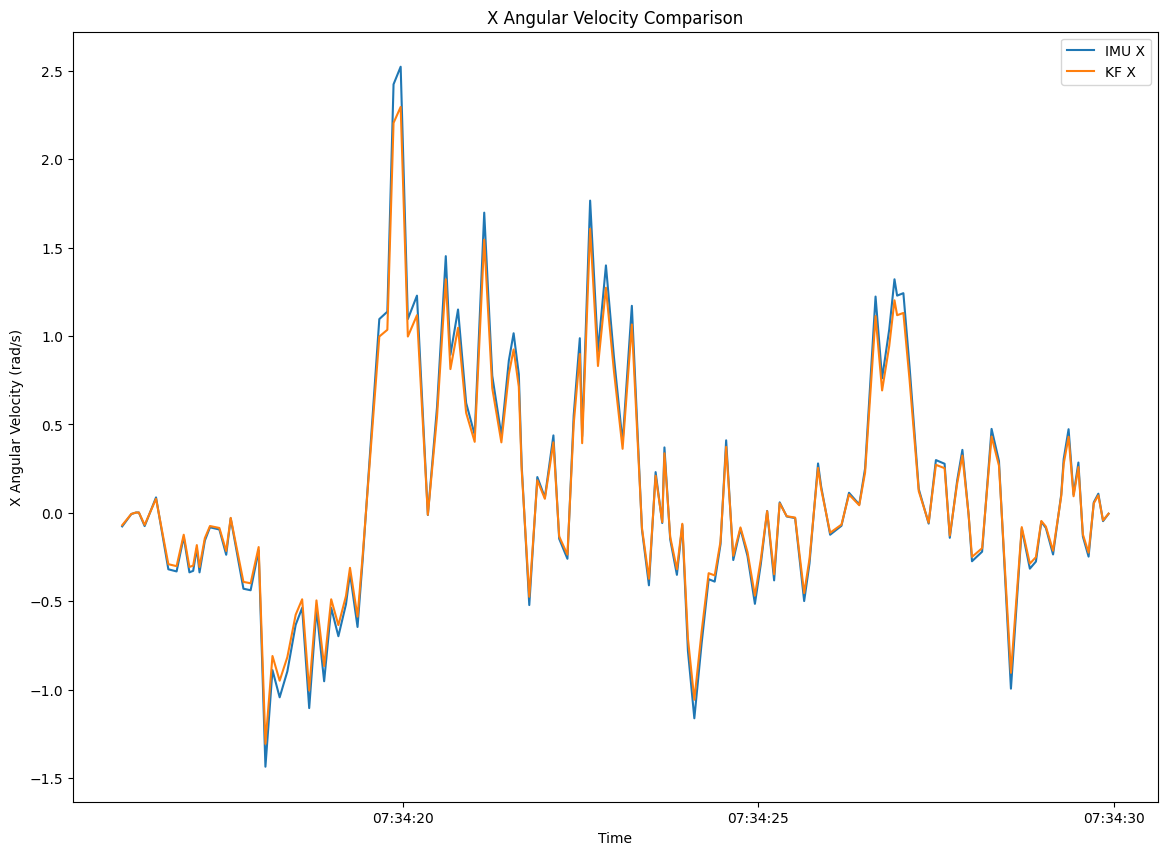

In [25]:
# 绘制 X 角速度时间序列
plt.figure(figsize=(14, 10))
plt.plot(df['timestamp'], df['imu_angular_velocity_x'], label='IMU X')
plt.plot(df['timestamp'], df['kf_angular_velocity_x'], label='KF X')
plt.xlabel('Time')
plt.ylabel('X Angular Velocity (rad/s)')
plt.legend()
plt.title('X Angular Velocity Comparison')
plt.show()

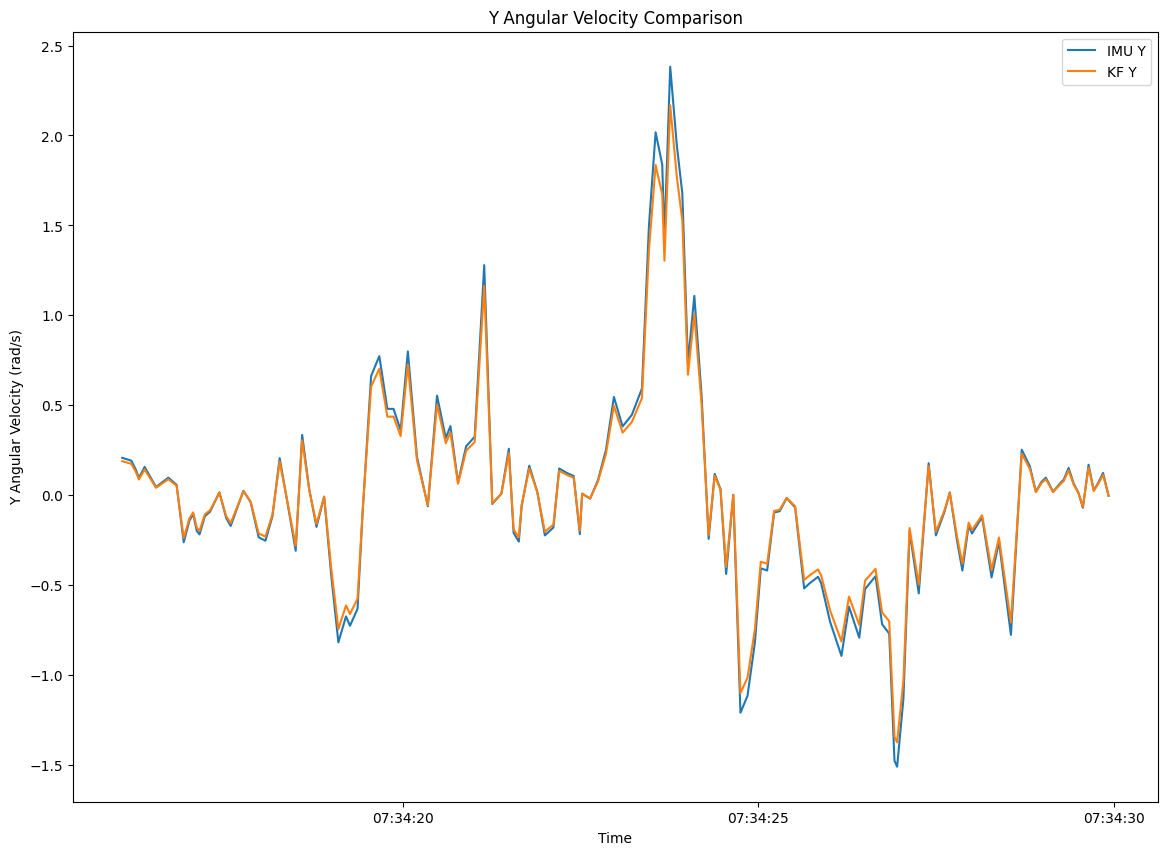

In [26]:
# 绘制 Y 角速度时间序列
plt.figure(figsize=(14, 10))
plt.plot(df['timestamp'], df['imu_angular_velocity_y'], label='IMU Y')
plt.plot(df['timestamp'], df['kf_angular_velocity_y'], label='KF Y')
plt.xlabel('Time')
plt.ylabel('Y Angular Velocity (rad/s)')
plt.legend()
plt.title('Y Angular Velocity Comparison')
plt.show()

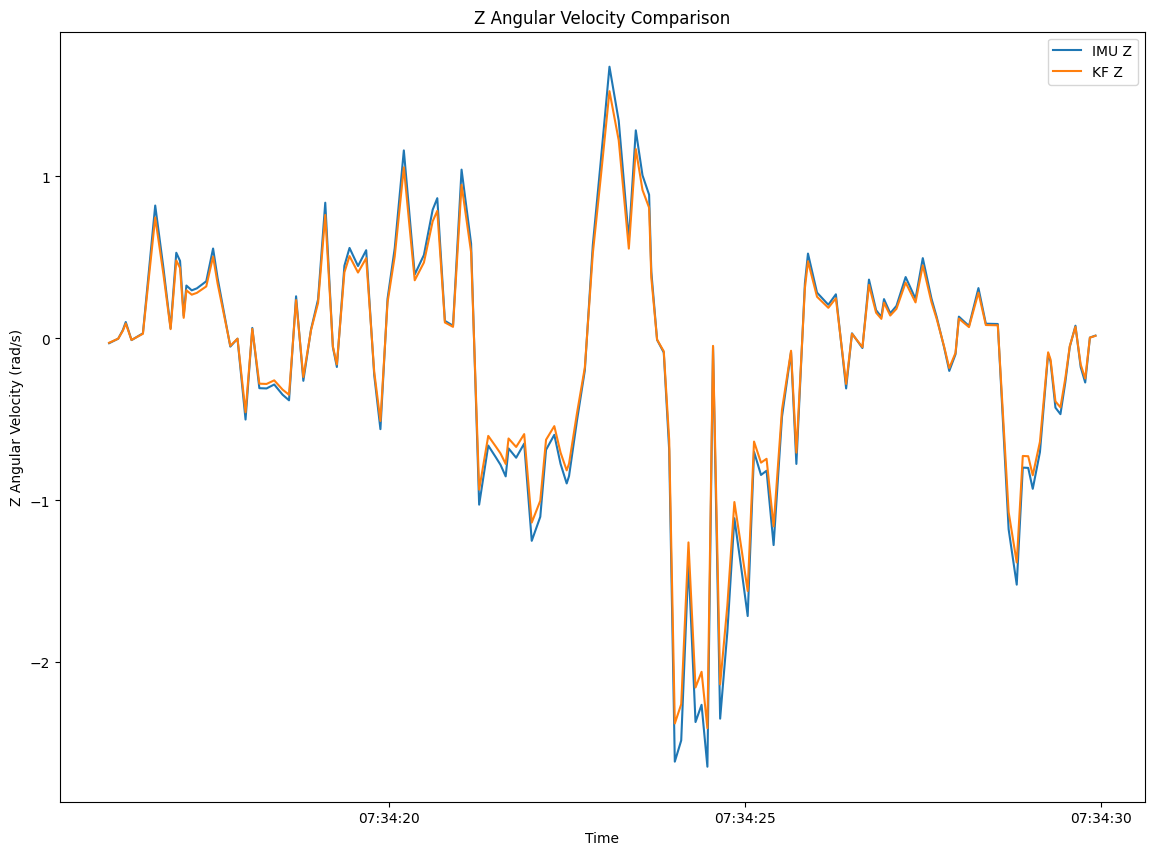

In [27]:
# 绘制 Z 角速度时间序列
plt.figure(figsize=(14, 10))
plt.plot(df['timestamp'], df['imu_angular_velocity_z'], label='IMU Z')
plt.plot(df['timestamp'], df['kf_angular_velocity_z'], label='KF Z')
plt.xlabel('Time')
plt.ylabel('Z Angular Velocity (rad/s)')
plt.legend()
plt.title('Z Angular Velocity Comparison')
plt.show()

In [28]:
# 计算加速度和角速度的方差
variance_imu_acc = df[['imu_acceleration_x', 'imu_acceleration_y', 'imu_acceleration_z']].var()
variance_kf_acc = df[['kf_acceleration_x', 'kf_acceleration_y', 'kf_acceleration_z']].var()

variance_imu_gyro = df[['imu_angular_velocity_x', 'imu_angular_velocity_y', 'imu_angular_velocity_z']].var()
variance_kf_gyro = df[['kf_angular_velocity_x', 'kf_angular_velocity_y', 'kf_angular_velocity_z']].var()

# 将结果合并为一个 DataFrame
variance_acc = pd.DataFrame({
    'IMU': variance_imu_acc.values,  # 只取数值部分
    'KF': variance_kf_acc.values,
    'Reduction (%)': (1 - variance_kf_acc.values / variance_imu_acc.values) * 100
}, index=['acceleration_x', 'acceleration_y', 'acceleration_z'])

variance_gyro = pd.DataFrame({
    'IMU': variance_imu_gyro.values,
    'KF': variance_kf_gyro.values,
    'Reduction (%)': (1 - variance_kf_gyro.values / variance_imu_gyro.values) * 100
}, index=['angular_velocity_x', 'angular_velocity_y', 'angular_velocity_z'])


print("加速度方差（原始 vs 滤波后）:")
print(variance_acc)

print("\n角速度方差（原始 vs 滤波后）:")
print(variance_gyro)

加速度方差（原始 vs 滤波后）:
                     IMU        KF  Reduction (%)
acceleration_x  0.409041  0.338660      17.206396
acceleration_y  0.181403  0.150190      17.206396
acceleration_z  0.698872  0.578621      17.206396

角速度方差（原始 vs 滤波后）:
                         IMU        KF  Reduction (%)
angular_velocity_x  0.453825  0.375738      17.206396
angular_velocity_y  0.360615  0.298566      17.206396
angular_velocity_z  0.635194  0.525900      17.206396
